In [1]:
from image.segmentation import BasicImageSegmenter
from ml.eval import eval_model
from ml.pipeline import FeitDataPipeline

from tensorflow.keras.applications import ResNet50

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import schedules

from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow import keras

from cfg import *

from livelossplot import PlotLossesKerasTF

import os
print(os.getcwd())
os.chdir('/home/jelinek/recetox/')


model_name = 'ResNet50_ImagenetWeightsTrainLast-512'

2022-02-04 13:52:44.291409: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-02-04 13:52:46.847682: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-02-04 13:52:46.847706: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-02-04 13:52:46.851888: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-02-04 13:52:46.904996: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2022-02-04 13:52:46.905530: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2022-02-04 13:52:46.907823: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so
2022-02-

/home/jelinek/recetox/src/notebooks


In [15]:
class MyResNet50(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params. name = model_name
        self.params.batch_size = 16
        self.params.tile_size = 512

        lr_schedule = schedules.ExponentialDecay(
                        initial_learning_rate=1e-1,
                        decay_steps=80,
                        decay_rate=0.1,
                        staircase=True)

        self.optimizer = ( Adam(
            learning_rate=lr_schedule,
            beta_1=0.99,
            beta_2=0.9999))


    @staticmethod
    def get_compiled_model():
        base_model = ResNet50(include_top=False,
                      input_shape=(512, 512, 3),
                      weights='imagenet',
                      pooling=None
                      )
        base_model.trainable = False

        inputs = keras.Input(shape=(512, 512, 3))
        x = base_model(inputs, training=False)
        x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
        outputs = keras.layers.Dense(12, activation='softmax', name='probs')(x)

        model = keras.Model(inputs, outputs)

        return model

    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)

        self.model.fit(data_train,
                       steps_per_epoch=200,
                       epochs=60,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()])

        print("Training done")

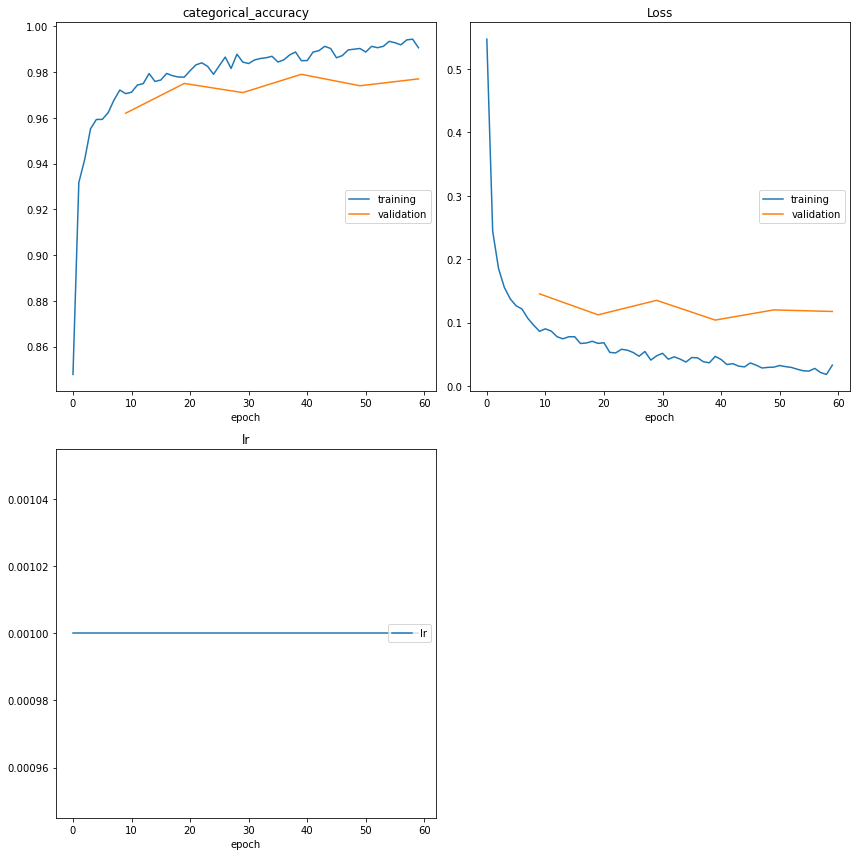

categorical_accuracy
	training         	 (min:    0.848, max:    0.994, cur:    0.991)
	validation       	 (min:    0.962, max:    0.979, cur:    0.977)
Loss
	training         	 (min:    0.018, max:    0.547, cur:    0.033)
	validation       	 (min:    0.104, max:    0.145, cur:    0.118)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
Training done


In [16]:
pipeline = MyResNet50(train_data_dir='data/Feit_colon-annotation-tiles-512/data_train/',
                      valid_data_dir='data/Feit_colon-annotation-tiles-512/data_valid/')

pipeline.execute_pipeline(perform_validation=False, perform_test_segmentation=False)

In [17]:
pipeline.save_pipeline()

In [4]:
eval_model(pipeline.model,
           pipeline.get_data_loader_validation(),
           print_confusion_matrix=True,
           save_misclassified=False)

Found 1001 images belonging to 12 classes.
63/63 [==============================] - 16s 245ms/step - loss: 0.1474 - categorical_accuracy: 0.9760
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 3.5235ms
Confusion Matrix
[[193   0   0   0   0   0   0   0   0   0   4   0]
 [  1  28   1   1   0   0   1   1   0   0   0   0]
 [  0   0  82   0   0   0   1   1   0   0   0   0]
 [  0   0   0   8   0   0   0   0   0   0   0   0]
 [  0   0   1   0 368   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0  50   1   0   0   2   0]
 [  0   0   0   0   0   0   0  62   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0   0]
 [  2   1   0   0   0   0   0   0   0   0 185   0]
 [  0   0   0   0   0   0   0   0   0   0   2   1]]
Classification Report
                             precision    recall  f1-score   support

             adenocarcinoma       0.97      0.98      0.9

In [2]:
pipeline = FeitDataPipeline.load_pipeline(model_name)


2022-02-04 13:52:48.573472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-04 13:52:48.573668: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-04 13:52:48.573727: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-02-04 13:52:48.587532: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-02-04 13:52:48.587668: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-02-04 13:52:48.615943: I tensorflow/stream_exec

In [3]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / model_name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir)

Processing region 1 out of 30

2022-02-04 13:52:52.481189: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-04 13:52:52.498082: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3399905000 Hz
2022-02-04 13:52:53.466667: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-02-04 13:52:53.981934: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2022-02-04 13:52:54.516127: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-04 13:52:54.516362: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2022-02-04 13:52:54.521233: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-04 13:52:54.521366: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31

Processing region 30 out of 30
Processing image took 8876.256577014923 seconds
Saving file...
File saved to segmentations/ResNet50_ImagenetWeightsTrainLast-512/ns-adenoca-colon-15071-2019-20x-he-4.tiff
Processing region 72 out of 72
Processing image took 21945.580193281174 seconds
Saving file...
File saved to segmentations/ResNet50_ImagenetWeightsTrainLast-512/ns-adenoca-colon-15072-2019-20x-he-a2.tiff
Processing region 6 out of 6
Processing image took 1301.8704545497894 seconds
Saving file...
File saved to segmentations/ResNet50_ImagenetWeightsTrainLast-512/ns-adenoca-colon-3043-2019-20x-he-a1-q.tiff


IndexError: index 97071 is out of bounds for axis 0 with size 96577